In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Reading file

In [2]:
orig = pd.read_csv("xhfile.csv")

In [3]:
df = orig.iloc[:,[2,4,3]]

In [4]:
df.columns = ["title", "desc", "tags"]

## Data preprocessing

In [5]:
df.shape

(786121, 3)

#### percent of missing values in each column

In [6]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
desc,402746,0.512321
tags,1002,0.001275
title,792,0.001007


#### how many are complete null rows

In [7]:
df[df.isnull().all(axis = 1)] # just one

,title,desc,tags
239432,NaN,NaN,NaN


In [8]:
# removing it
df = df.drop([239432])

# verifying if dropped
len(df[df.isnull().all(axis = 1)]) # yes

0

#### removing rows with missing data: this will reduce the size of data to half as desc has almost 51% missing data.

In [9]:
df = df[~df.isnull().any(axis = 1)] # just one
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383051 entries, 0 to 786116
Data columns (total 3 columns):
title    383051 non-null object
desc     383051 non-null object
tags     383051 non-null object
dtypes: object(3)
memory usage: 11.7+ MB


#### checking for duplicates records

In [10]:
len(df[df.duplicated()])

3958

#### dropping duplicate records

In [11]:
df = df.drop_duplicates()
len(df[df.duplicated()]) # no more duplicates

0

In [12]:
df = df.reset_index(drop=True)

#### converting title and desc to lowercase and then checking for dups

In [13]:
df.title = df.title.str.lower()
df.desc = df.desc.str.lower()

In [14]:
len(df[df.duplicated()]) 

225

In [15]:
# dropping these 225 records
df = df.drop_duplicates().reset_index(drop=True)
len(df[df.duplicated()]) # no more duplicates

0

#### converting string representation of list to list under tags column

In [16]:
import ast
df.iloc[:,2] = df.iloc[:,2].apply(lambda x: ast.literal_eval(x))

#### frequency of tags

In [17]:
taglst = []
for i in range(df.iloc[:,2].count()):
    for j in range(len(df.iloc[i,2])):
        taglst.append(df.iloc[i,2][j])        

In [18]:
len(set(taglst)) # 92 unique records

92

#### plot of highest frequent terms

In [19]:
val, cnt = np.unique(taglst, return_counts=True)
idx = np.argsort(cnt)[::-1]

In [1]:
uf = pd.DataFrame([val[idx], cnt[idx]]).T.rename(columns=dict(zip(range(2), ["Tags","Hits"])))

In [22]:
unifreq = pd.DataFrame([val[idx][:10], cnt[idx][:10]]).T
unifreq.columns = ["Tags", "Hits"]

In [2]:
sns.barplot(x = "Hits", y = "Tags", 
            data = unifreq, palette="GnBu_d")

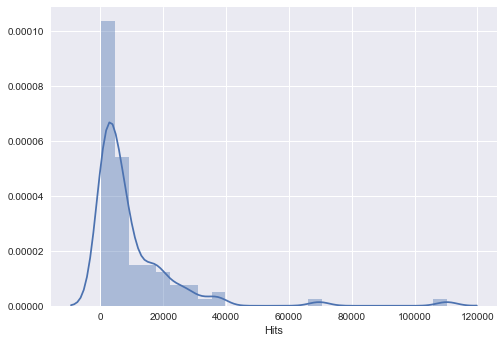

In [24]:
sns.distplot(uf.Hits)

## Splitting data into training, validation and testing portions (70:10:20)

In [25]:
np.random.seed(42)
dfa, dfz, dfv = np.split(df.sample(frac=1), # 1 means complete data (100%)
                         [int(.7*len(df)), int(.9*len(df))]) # 0.7% | 1-0.9 = 0.1% | 0.9-0.7=0.2%
dfa = dfa.reset_index(drop=True)
dfz = dfz.reset_index(drop=True)
dfv = dfv.reset_index(drop=True)

#### Title association

In [26]:
from nltk.corpus import stopwords
sw = list(stopwords.words('english'))

In [28]:
# removing Title stopwords and fetching all other words
dfa.iloc[:,0] = dfa.iloc[:,0].apply(lambda x : " ".join(item for item in x.split() if item not in sw))
title = ""
for i in range(dfa.title.count()):
    title = title + " " + dfa.iloc[i,0]
title = list(set(title.split()))

# removing Desc stopwords and fetching all other words
dfa.iloc[:,1] = dfa.iloc[:,1].apply(lambda x : " ".join(item for item in x.split() if item not in sw))
desc = ""
for i in range(dfa.title.count()):
    desc = desc + " " + dfa.iloc[i,1]
desc = list(set(desc.split()))

tdf = pd.DataFrame("", index = range(len(desc)),columns=["Title words","Desc words","Associated tags"])
tdf.iloc[:len(title),0] = title
tdf.iloc[:len(desc),1] = desc

joint = list((set(tdf.iloc[:,0])) & (set(tdf.iloc[:,1])))
union = list((set(tdf.iloc[:,0])) | (set(tdf.iloc[:,1])))
tw = list((set(tdf.iloc[:,0])) - (set(tdf.iloc[:,1])))
ds = list((set(tdf.iloc[:,1])) - (set(tdf.iloc[:,0])))

In [390]:
# joint words are not signifying that these words will appear in both title and desc in same row.

# So finding the words which occurs together in both title and desc in same row
jointdf = pd.DataFrame("0", index = range(len(union)), columns = ["Jword", "Tags"])
jointdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164403 entries, 0 to 164402
Data columns (total 2 columns):
Jword    164403 non-null object
Tags     164403 non-null object
dtypes: object(2)
memory usage: 2.5+ MB


In [391]:
# code to bring intersection words between title and desc and corresponding tags

import ast

cnt = 0
for i in range(0,dfa.shape[0]):
    
    # taking intersection and removing stopwords
    wrd = list((set(dfa.iloc[i,0].split()) & set(dfa.iloc[i,1].split())) - set(sw))     
    
    if len(wrd) >= 1:
        for j in range(len(wrd)):
            
            # CASE 1: When new word needs to be entered
            
            if wrd[j] not in list(jointdf.Jword):
                
                jointdf.iloc[cnt, 0] = wrd[j]           # feeding new word                
                for k in range(len(dfa.iloc[i,2])):                    
                    jointdf.iloc[cnt, 1] = jointdf.iloc[cnt, 1].replace("0", str({dfa.iloc[i,2][k]:1}))
                cnt += 1
                
            else:                
                # finding the index of the present word
                for k in range(jointdf.shape[0]):
                    if wrd[j] == jointdf.iloc[k,0]:
                        break                           # Hence, word is present at kth index
                        
                d = ast.literal_eval(jointdf.iloc[k,1]) # converting string representation of dict to dict                
                
                for g in range(len(dfa.iloc[i,2])):
                    tag_present = 0                     # State; checking if tag already present or not                
                    for key,v in d.items():                                                
                        if dfa.iloc[i,2][g] == key:                            
                            tag_present = 1
                            break                    
                    
            # CASE 2: Word already there but a new keyword needs to be added rather than updating existing one                    
                    
                    if tag_present == 0:                        
                        jointdf.iloc[k,1] = jointdf.iloc[k,1][:-1] + "," + str({dfa.iloc[i,2][g]:1})[1:]                         
                    
            # CASE 3: Updating the current tag occurence value
            
                    else:              
                        d = ast.literal_eval(jointdf.iloc[k,1]) # converting latest dict
                        d[dfa.iloc[i,2][g]] += 1                                                
                        jointdf.iloc[k,1] = str(d)             

In [75]:
# ----------------------------- Words occuring only in title and their associated keywords ------------
titledf = pd.DataFrame("0", index = range(50000), columns = ["Tword", "Tags"])
titledf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
Tword    50000 non-null object
Tags     50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [94]:
# code to bring title words and corresponding tags

import ast

cnt = 50000
for i in range(233900,dfa.shape[0]): #dfa.shape[0]
    
    # taking intersection and removing stopwords
    wrd = list((set(dfa.iloc[i,0].split()) - set(dfa.iloc[i,1].split())) - set(sw))         
    if "0" in wrd:
        wrd.remove("0")        
    if len(wrd) >= 1:
        for j in range(len(wrd)):
            
            # CASE 1: When new word needs to be entered
            
            if wrd[j] not in list(titledf.Tword):
                
                titledf.iloc[cnt, 0] = wrd[j]           # feeding new word                
                for k in range(len(dfa.iloc[i,2])):                    
                    titledf.iloc[cnt, 1] = titledf.iloc[cnt, 1].replace("0", str({dfa.iloc[i,2][k]:1}))
                cnt += 1
                
            else:                
                # finding the index of the present word
                for k in range(titledf.shape[0]):
                    if wrd[j] == titledf.iloc[k,0]:
                        break                           # Hence, word is present at kth index
                        
                d = ast.literal_eval(titledf.iloc[k,1]) # converting string representation of dict to dict                
                
                for g in range(len(dfa.iloc[i,2])):
                    tag_present = 0                     # State; checking if tag already present or not                
                    for key,v in d.items():                                                
                        if dfa.iloc[i,2][g] == key:                            
                            tag_present = 1
                            break                    
                    
            # CASE 2: Word already there but a new keyword needs to be added rather than updating existing one                    
                    
                    if tag_present == 0:                        
                        titledf.iloc[k,1] = titledf.iloc[k,1][:-1] + "," + str({dfa.iloc[i,2][g]:1})[1:]                         
                    
            # CASE 3: Updating the current tag occurence value
            
                    else:              
                        d = ast.literal_eval(titledf.iloc[k,1]) # converting latest dict
                        d[dfa.iloc[i,2][g]] += 1                                                
                        titledf.iloc[k,1] = str(d)           

In [93]:
# Perform same for separate content words